In [1]:
import sys
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams["image.interpolation"] = "none"
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 5
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)

Load analyzed and post-processed nuclei data for each slide:

In [2]:
def load_data(folder, filename="data.xlsx", root="images"):
    data = pd.read_excel(os.path.join(root, folder, "results", filename), index_col=0)
    if os.path.exists(os.path.join(root, folder, "qc_images", "curated2.xlsx")):
        print("loading manual annotations for", folder)
        data["aggregate"] &= pd.read_excel(
            os.path.join(root, folder, "qc_images", "curated2.xlsx"), index_col=0
        )["aggregate"]
    return data

In [21]:
samples = [
    "NIID1_skin",
    "FXTAS5006_P",
    "FXTAS5006_CB",
    "FXTAS5006_BA8",
    "FXTAS5006_BA24",
    "FXTAS5746_P",
    "FXTAS5746_CB",
    "FXTAS5746_BA8",
    "FXTAS5746_BA24",
    "FXTAS4555_P",
    "FXTAS4555_CB",
    "FXTAS4555_BA8",
    "FXTAS4555_BA24",
    "cell_block_A1",
    "cell_block_A2",
    "FXTAS5006_CB-RTCB",
    "FXTAS5006_CB-DDX1",
    "FXTAS5006_CB-RTRAF",
    "FXTAS5006_CB-p62",
]
data_file = {
    s: "data2.xlsx" for s in samples
}

data = {}
for s in samples:
    data[s] = load_data(s, filename=data_file.get(s, "data.xlsx"))
    print(s)
    print(data[s]["aggregate"].value_counts())

loading manual annotations for NIID1_skin
NIID1_skin
False    937
True      33
Name: aggregate, dtype: int64
FXTAS5006_P
False    619
True     164
Name: aggregate, dtype: int64
FXTAS5006_CB
False    2509
True      206
Name: aggregate, dtype: int64
FXTAS5006_BA8
False    459
True     165
Name: aggregate, dtype: int64
FXTAS5006_BA24
False    1203
True      189
Name: aggregate, dtype: int64
FXTAS5746_P
False    1209
True      284
Name: aggregate, dtype: int64
FXTAS5746_CB
False    11518
True       278
Name: aggregate, dtype: int64
FXTAS5746_BA8
False    1166
True      346
Name: aggregate, dtype: int64
FXTAS5746_BA24
False    1506
True      243
Name: aggregate, dtype: int64
FXTAS4555_P
False    1107
True       54
Name: aggregate, dtype: int64
FXTAS4555_CB
False    8592
True       51
Name: aggregate, dtype: int64
FXTAS4555_BA8
False    1128
True       44
Name: aggregate, dtype: int64
FXTAS4555_BA24
False    989
True      51
Name: aggregate, dtype: int64
cell_block_A1
Series([], Name: aggreg

Plotting functions:

In [4]:
from mpl_toolkits.axes_grid1 import Divider, Size
from matplotlib.colors import to_rgba
import matplotlib.patheffects as pe

# plot one set of points
def plot_points(x, y, hue, c, seed=42, ax=None):
    np.random.seed(seed)

    # randomly subset points to plot if too many
    if len(y) > 1000:
        idxs = np.random.choice(len(y), size=1000, replace=False)
        y, hue = y[idxs], hue[idxs]

    # try to inversely scale alpha with number of points
    alpha = np.clip(2 / len(y) ** 0.5, 0, 1)

    # plot points
    p = sns.stripplot(
        x=x,
        y=y,
        # use hue (True / False) to mask points above or below axis break
        hue=hue,
        palette={True: to_rgba(c, alpha), False: "none"},
        jitter=0.3,
        lw=0,
        size=3,
        orient="v",
        legend=False,
        # show complete point near axis break
        clip_on=False,
        ax=ax,
    )

    # plot mean line and white outline
    p.hlines(
        np.nanmean(y),
        x - 0.2 - 0.0396825397 / 2,
        x + 0.2 + 0.0396825397 / 2,
        zorder=9,
        color="w",
        lw=2,
    )
    p.hlines(
        np.nanmean(y),
        x - 0.2,
        x + 0.2,
        zorder=10,
        color=c,
        lw=1,
    )


def plot_data(
    data,
    stat,
    ax=None,
    background="background",
    title=None,
    lim=1000,
    pal=["k", "darkred"],
    ticks=["No", "Yes"],
):
    df = data.copy()
    df["subtracted"] = df[stat] - df[background]
    no, yes = (
        df[~df["aggregate"]]["subtracted"].values,
        df[df["aggregate"]]["subtracted"].values,
    )

    # set axis break to the given multiple of the mean for No
    if isinstance(lim, (tuple, list)) and len(lim) == 2 and lim[0] == "ratio":
        lim = np.nanmean(no) * lim[1]
    axis_break = any(no > lim) or any(yes > lim)

    if ax is None:
        h = [Size.Scaled(1), Size.Fixed(0.7), Size.Scaled(0.2)]
        if axis_break:
            v = [
                Size.Scaled(1.25),
                Size.Fixed(0.4),
                Size.Fixed(0.025),
                Size.Fixed(0.9),
                Size.Scaled(2.25),
            ][::-1]
        else:
            v = [
                Size.Scaled(1.25),
                Size.Fixed(0),
                Size.Fixed(0),
                Size.Fixed(1.35),
                Size.Scaled(2.25),
            ][::-1]
        fig = plt.figure(figsize=(1.105, 1.8))
        divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)

    # below axis break
    ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    # above axis break
    ax1 = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=3)
    )

    # plot points below axis break
    plot_points(False, no, no < lim, pal[0], ax=ax)
    plot_points(True, yes, yes < lim, pal[1], ax=ax)

    # plot points above axis break
    if axis_break:
        plot_points(False, no, no > lim, pal[0], ax=ax1)
        plot_points(True, yes, yes > lim, pal[1], ax=ax1)

    # annotate relative mean value of Yes vs. No
    ax.annotate(
        f"{np.nanmean(yes) / np.nanmean(no):.2f}",
        xy=(1.2, np.nanmean(yes)),
        xycoords="data",
        xytext=(2, 0),
        textcoords="offset points",
        c=pal[1],
        fontweight="bold",
        va="center",
        path_effects=[pe.Stroke(linewidth=1, foreground="w"), pe.Normal()],
    )

    # draw asterisks
    annotator = Annotator(
        ax1 if axis_break else ax,
        [(False, True)],
        data=df,
        y="subtracted",
        x="aggregate",
        color="k",
        orient="v",
    )
    annotator.configure(test="t-test_ind", line_width=0.5)
    annotator.apply_test().annotate(line_offset_to_group=0.2 if axis_break else None)

    ax.set_xticks(
        ticks=[0, 1],
        labels=[
            f"{ticks[0]}\n($\\it{{n}}$={len(no):,})",
            f"{ticks[1]}\n($\\it{{n}}$={len(yes):,})",
        ],
    )
    ax.set_xlim((-0.5, 1.5))
    ax.set_xlabel("intranuclear inclusion", labelpad=2)
    ax.tick_params(axis="x", which="both", length=2.5, pad=2)

    ax.set_ylim((-0.1 * lim, lim if axis_break else None))
    sns.despine(ax=ax)

    ax1.set_ylim((lim, None))
    ax1.set_xlim((-0.5, 1.5))
    sns.despine(ax=ax1, bottom=True, left=not axis_break)
    ax1.set_xticks([])
    if not axis_break:
        ax1.set_yticks([])

    ax.tick_params(axis="y", which="major", pad=1, length=2.5)
    ax1.tick_params(axis="y", which="major", pad=1, length=2.5)

    fig.supylabel("median FAM98B intensity", size=5)

    ax1.set_title(title, fontdict={"size": 5})

    # draw axis break
    def diagonal(ax, coords):
        d = 0.02
        figsize = fig.get_size_inches()
        xy = (
            fig.transFigure.inverted().transform(ax.transAxes.transform(coords))
            * figsize
        )
        return (xy - d) / figsize, (xy + d) / figsize

    if axis_break:
        kwargs = dict(transform=fig.transFigure, color="k", clip_on=False, lw=1)
        a0, b0 = diagonal(ax, (0, 1))
        ax.plot((a0[0], b0[0]), (a0[1], b0[1]), **kwargs)
        a1, b1 = diagonal(ax1, (0, 0))
        ax1.plot((a1[0], b1[0]), (a1[1], b1[1]), **kwargs)

    return fig, [ax, ax1]

In [5]:
YLIM_RATIO = 2.5

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:1.410e-04 t=3.822e+00


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'NIID skin'}>])

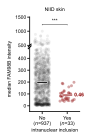

In [7]:
plot_data(data["NIID1_skin"], "gmm2", title="NIID skin", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:1.220e-03 t=3.246e+00


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#5006 pons'}>])

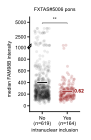

In [8]:
plot_data(data["FXTAS5006_P"], "gmm2", title="FXTAS#5006 pons", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:1.866e-45 t=1.442e+01


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#5006 cerebellum'}>])

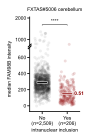

In [9]:
plot_data(data["FXTAS5006_CB"], "gmm2", title="FXTAS#5006 cerebellum", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:3.389e-08 t=5.591e+00


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#5006 BA8'}>])

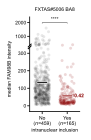

In [10]:
plot_data(data["FXTAS5006_BA8"], "gmm2", title="FXTAS#5006 BA8", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:7.758e-03 t=2.666e+00


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#5006 BA24'}>])

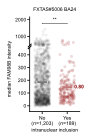

In [11]:
plot_data(data["FXTAS5006_BA24"], "gmm2", title="FXTAS#5006 BA24", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:5.479e-55 t=1.628e+01


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#5746 pons'}>])

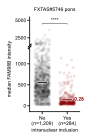

In [12]:
plot_data(data["FXTAS5746_P"], "gmm2", title="FXTAS#5746 pons", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:6.687e-69 t=1.766e+01


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#5746 cerebellum'}>])

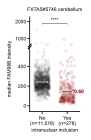

In [13]:
plot_data(data["FXTAS5746_CB"], "gmm2", title="FXTAS#5746 cerebellum", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:4.701e-52 t=1.578e+01


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#5746 BA8'}>])

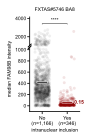

In [14]:
plot_data(data["FXTAS5746_BA8"], "gmm2", title="FXTAS#5746 BA8", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:2.839e-28 t=1.122e+01


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#5746 BA24'}>])

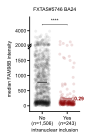

In [15]:
plot_data(data["FXTAS5746_BA24"], "gmm2", title="FXTAS#5746 BA24", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:1.640e-04 t=3.781e+00


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#4555 pons'}>])

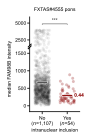

In [16]:
plot_data(data["FXTAS4555_P"], "gmm2", title="FXTAS#4555 pons", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:4.730e-13 t=7.244e+00


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#4555 cerebellum'}>])

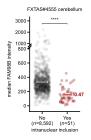

In [17]:
plot_data(data["FXTAS4555_CB"], "gmm2", title="FXTAS#4555 cerebellum", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:6.172e-06 t=4.541e+00


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#4555 BA8'}>])

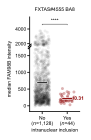

In [18]:
plot_data(data["FXTAS4555_BA8"], "gmm2", title="FXTAS#4555 BA8", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:1.746e-07 t=5.260e+00


(<Figure size 110.5x180 with 2 Axes>,
 [<Axes: xlabel='intranuclear inclusion'>,
  <Axes: title={'center': 'FXTAS#4555 BA24'}>])

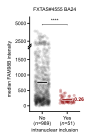

In [19]:
plot_data(data["FXTAS4555_BA24"], "gmm2", title="FXTAS#4555 BA24", lim=("ratio", YLIM_RATIO))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:7.198e-297 t=4.707e+01


Text(0.5, 9.2579365079365, 'FAM98B')

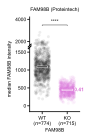

In [22]:
fig, axs = plot_data(
    data["cell_block_A1"].assign(aggregate=lambda df: df["knockout"]),
    "quartiles-1",
    title="FAM98B (Proteintech)",
    lim=("ratio", 1.5),
    pal=("k", "orchid"),
    ticks=["WT", "KO"]
)
axs[0].set_xlabel("FAM98B")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:0.000e+00 t=6.194e+01


Text(0.5, 9.2579365079365, 'FAM98B')

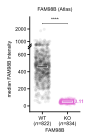

In [23]:
fig, axs = plot_data(
    data["cell_block_A2"].assign(aggregate=lambda df: df["knockout"]),
    "quartiles-1",
    title="FAM98B (Atlas)",
    lim=("ratio", 1.5),
    pal=("k", "orchid"),
    ticks=["WT", "KO"]
)
axs[0].set_xlabel("FAM98B")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:3.222e-41 t=1.350e+01


Text(0.02, 0.5, 'median RTCB intensity')

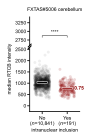

In [24]:
fig, axs = plot_data(data["FXTAS5006_CB-RTCB"], "gmm2", title="FXTAS#5006 cerebellum", lim=("ratio", YLIM_RATIO))
fig.supylabel("median RTCB intensity", size=5)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:7.388e-16 t=8.074e+00


Text(0.02, 0.5, 'median DDX1 intensity')

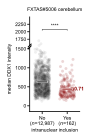

In [25]:
fig, axs = plot_data(data["FXTAS5006_CB-DDX1"], "gmm2", title="FXTAS#5006 cerebellum", lim=("ratio", YLIM_RATIO))
fig.supylabel("median DDX1 intensity", size=5)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:3.373e-41 t=1.351e+01


Text(0.02, 0.5, 'median RTRAF intensity')

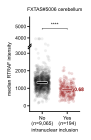

In [26]:
fig, axs = plot_data(data["FXTAS5006_CB-RTRAF"], "gmm2", title="FXTAS#5006 cerebellum", lim=("ratio", YLIM_RATIO))
fig.supylabel("median RTRAF intensity", size=5)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:2.092e-110 t=-2.257e+01


Text(0.02, 0.5, 'median p62 intensity')

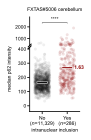

In [27]:
fig, axs = plot_data(data["FXTAS5006_CB-p62"], "gmm2", title="FXTAS#5006 cerebellum", lim=("ratio", YLIM_RATIO))
fig.supylabel("median p62 intensity", size=5)